# 요약 (Summarization )
`14_summarization.ipynb`

매우 많은 양의 컨텍스트가 있을 경우, 어떻게 요약을 해야 할까?
1. 프롬프트에 다 때려 박기
2. Map-Reduce: 각 문서를 요약하고, 이것들을 다 합쳐서 최종 요약본을 만든다.

In [ ]:
from dotenv import load_dotenv

load_dotenv()

In [ ]:
%pip install -q arxiv

In [ ]:
from langchain_community.document_loaders import WebBaseLoader, ArxivLoader

loader = ArxivLoader(
    query='reasoning',
)

docs = loader.load()
docs = docs[:2]
len(docs)

In [93]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o', temperature=0)

## 문서 때려 박기 (Stuff Docs)

In [94]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages([
    ('system', '아래 내용을 정확하게 요약해: \n\n{context}')
])

chain = create_stuff_documents_chain(llm, prompt)

res = chain.invoke({'context': docs})

In [95]:
print(res)

The article "LLM Powered Autonomous Agents" by Lilian Weng discusses the concept of building autonomous agents using large language models (LLMs) as the core controller. It outlines the components of such a system, including planning, memory, and tool use. The planning component involves task decomposition and self-reflection, while the memory component distinguishes between short-term and long-term memory, utilizing techniques like Maximum Inner Product Search (MIPS) for fast retrieval. The tool use component highlights the integration of external APIs to enhance the agent's capabilities. The article also presents case studies, such as ChemCrow for scientific discovery and Generative Agents for simulating human behavior. Challenges like finite context length, long-term planning, and the reliability of natural language interfaces are discussed. The article concludes with proof-of-concept examples like AutoGPT and GPT-Engineer, showcasing the potential and limitations of LLM-powered age

## Map - Reduce
- 각각 나눠서 요약하기

In [96]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages([
    ('system', '아래 내용을 정확하게 요약해: \n\n{context}')
])

In [97]:
from langchain_community.document_loaders import ArxivLoader

loader = ArxivLoader(query='reasoning')
docs = loader.load()
len(docs)

3

In [98]:
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

### Langgrpah로 문서별 요약 작업 조율

In [99]:
# 문서를 더 작은 문서로 쪼개기
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000,  # tiktoken 인코더라 토큰 기준 1000개
    chunk_overlap=0,
)

split_docs = text_splitter.split_documents(docs)
len(split_docs)

Created a chunk of size 1003, which is longer than the specified 1000


13

In [100]:
import operator
from typing_extensions import Annotated, List, Literal, TypedDict

from langchain.chains.combine_documents.reduce import acollapse_docs, split_list_of_docs
from langchain_core.documents import Document
from langgraph.types import Send
from langgraph.graph import START, END, StateGraph


# 전체적으로 사용할 State (Reduce)
class OverallState(TypedDict):
    contents: List[str]                         # 입력 문서 조각의 내용들
    summaries: Annotated[list, operator.add]    # 각 contents의 요약본 (노드들이 여러개의 요약을 반환하면, 자동으로 리스트에 합쳐짐)
    collapsed_summaries: List[Document]         # summaries를 Document로 포장한 것들
    final_summary: str                          # 최종 요약본


# 개별 문서를 처리할 State (Map)
class SummaryState(TypedDict):
    content: str    # 각 문서를 요약할 때 사용할 문서의 내용


In [101]:
TOKEN_MAX = 1000

map_prmopt = ChatPromptTemplate.from_messages([
    ('system', '아래 내용의 정확한 요약을 해\n\n{context}')
])

reduce_template = """
아래는 요약된 문서들이야.

{docs}
---
이것들을 가지고 정제해서 최종 통합본을 잘 만들어줘.
"""

reduce_prompt = ChatPromptTemplate([
    ('human', reduce_template)
])


In [102]:
# Node, Router 아닌 실제 사용할 함수들

async def _reduce(input: dict) -> str:
    prompt = reduce_prompt.invoke(input)
    res = await llm.ainvoke(prompt)
    return res.content

# documents 인자 내부의 모든 내용의 토큰 총 합
def sum_docs_tokens(documents: List[Document]) -> int:
    return sum(llm.get_num_tokens(doc.page_content) for doc in documents)

In [ ]:
# Edge (router) -> 각 원본조각을 요약할수 있게 generate_summary 로 보냄 (문서 조각 개수만큼)
def map_summaries(state: OverallState):
    result = []
    for content in state['contents']:
        result.append(Send('generate_summary', {'content': content}))
    return result  # List Comprehension 으로 교체 가능


# Edge (router) -> 재귀적으로 계속 collapse_suammries 를 할지, 끝낼지 결정하는 라우터
def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = sum_docs_tokens(state["collapsed_summaries"])
    if num_tokens > TOKEN_MAX:
        return "collapse_summaries"
    else:
        return "generate_final_summary"


# Node: 주어진 내용을 요약함. (비동기적 실행)
async def generate_summary(state: SummaryState):
    prompt = map_prmopt.invoke({'context': state['content']})
    res = await llm.ainvoke(prompt)
    return {'summaries': [res.content]}


# Node: 위에서 생성한 요약들을 Document() 객체로 만들어서 'collapsed_summaries' 키에 넣어줌
def collect_summaries(state: OverallState):
    return {
        'collapsed_summaries': [Document(summary) for summary in state['summaries']]
    }


# Node: 1차 요약이 완료. -> 요약본이 토큰수가 너무 많을 수 있다 -> 필요에 따라 더 작은 요약으로 축소(collapse)
async def collapse_summaries(state: OverallState):
    docs_lists = split_list_of_docs(
        state['collapsed_summaries'],
        sum_docs_tokens,
        TOKEN_MAX
    )
    results = []
    for doc_list in docs_lists:
        results.append(await acollapse_docs(doc_list, _reduce))

    return {'collapsed_summaries': results}


# Node: 최종 정리 노드
async def generate_final_summary(state: OverallState):
    response = await _reduce(state["collapsed_summaries"])
    return {"final_summary": response}

In [104]:
# Construct the graph
# Nodes:
graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)  # same as before
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("collapse_summaries", collapse_summaries)
graph.add_node("generate_final_summary", generate_final_summary)

# Edges:
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)

app = graph.compile()

In [ ]:
async for step in app.astream(
    {'contents': [doc.page_content for doc in split_docs]},
    {'recursion_limit': 10}
):
    print(step)

{'generate_summary': {'summaries': ['The document outlines a set of commands and resources available for task execution, including internet searches, website browsing, GPT agent management, file operations, code analysis, and more. It emphasizes the importance of efficiency, self-evaluation, and strategic decision-making to optimize performance. The document also highlights the use of GPT-3.5 powered agents for task delegation and provides guidelines for continuous improvement and cost-effective task completion.']}}
{'generate_summary': {'summaries': ["The document discusses the limitations and challenges faced by LLM-powered autonomous agents. It highlights the finite context length, which restricts the inclusion of historical information and detailed instructions, impacting the system's ability to learn from past mistakes. Long-term planning and task decomposition are also challenging, as LLMs struggle to adjust plans when encountering unexpected errors. Additionally, the reliability

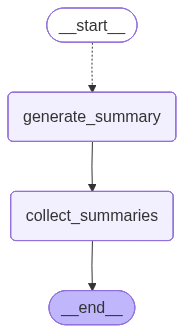

In [62]:
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())